<a href="https://colab.research.google.com/github/yousseflashin/smart-inventory-optimizer/blob/ATOM_USER_Model_Architecture/model/notebooks/ATOM_USER_Model_Architecture_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

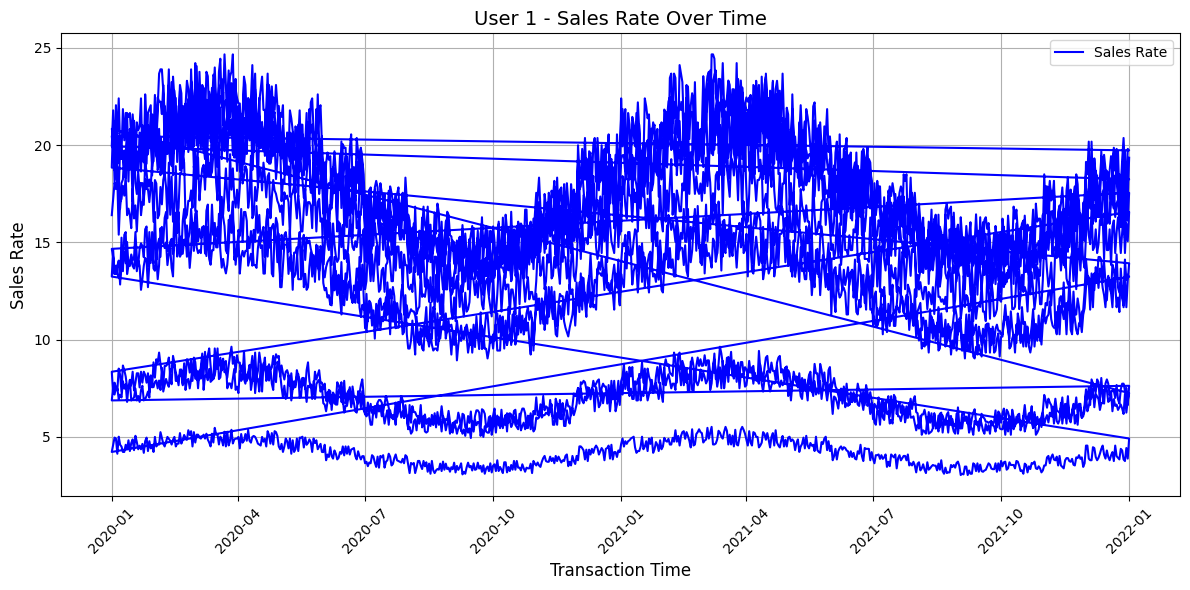

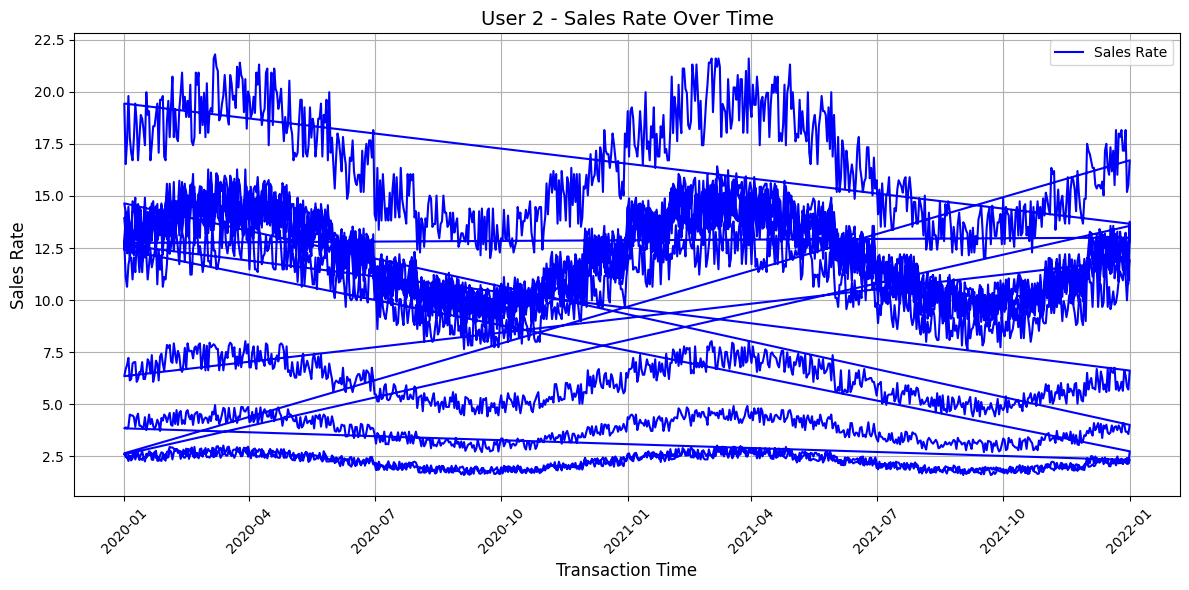


Training and Predicting for User 1...
User 1 - MAE: 0.74, MSE: 0.93


<ipython-input-1-407a5201e75c>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['Transaction Time'] = pd.to_datetime(user_data['Transaction Time'], errors='coerce')


Top Predicted Products for User 1:
     Product Name  predicted_sales_rate
6587    Product_9             19.357935
5855    Product_8             17.988789
7319   Product_10             17.514217
2927    Product_4             17.499538
731     Product_1             15.499851
3659    Product_5             13.224236
5123    Product_7             12.663873


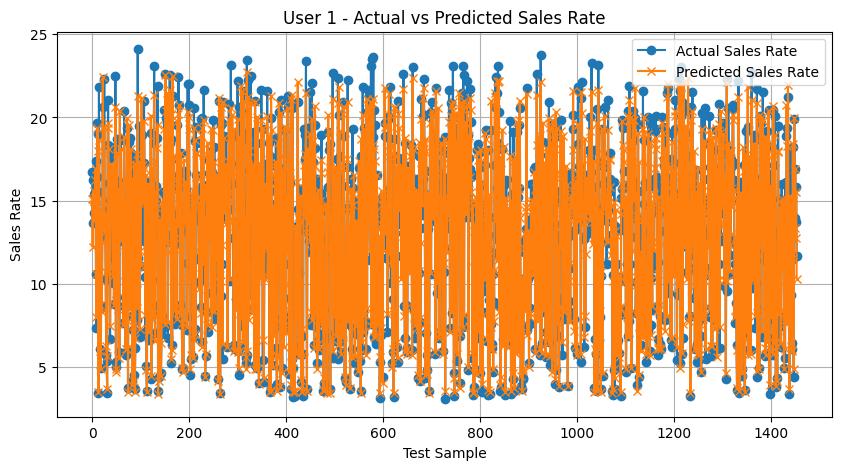

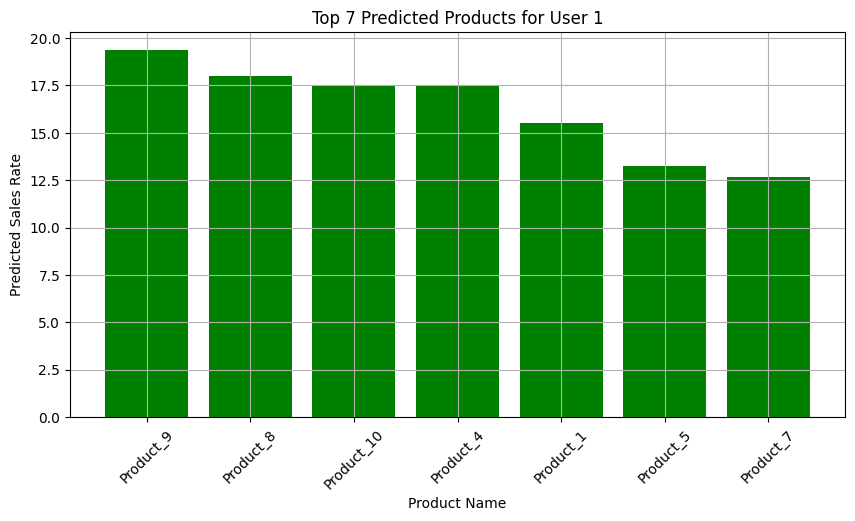


Training and Predicting for User 2...
User 2 - MAE: 0.51, MSE: 0.49


<ipython-input-1-407a5201e75c>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['Transaction Time'] = pd.to_datetime(user_data['Transaction Time'], errors='coerce')


Top Predicted Products for User 2:
      Product Name  predicted_sales_rate
8783     Product_2             16.546740
14639   Product_10             12.533322
10979    Product_5             12.487677
8051     Product_1             12.308997
13175    Product_8             12.188751
11711    Product_6             11.124269
12443    Product_7              6.113738


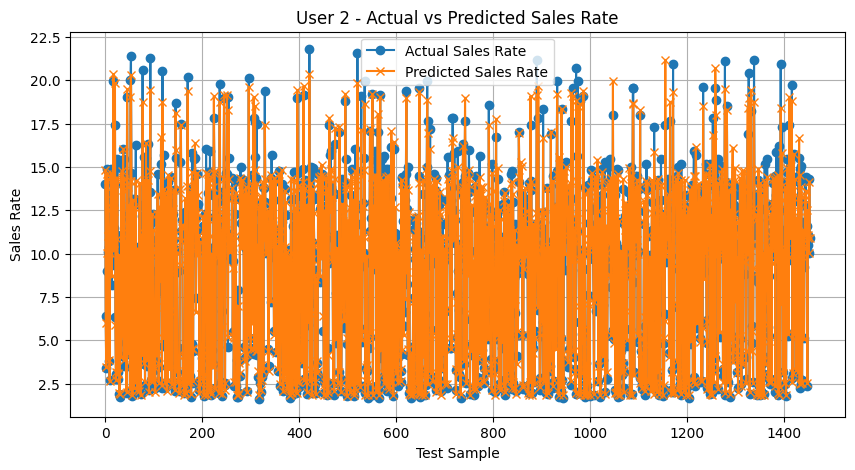

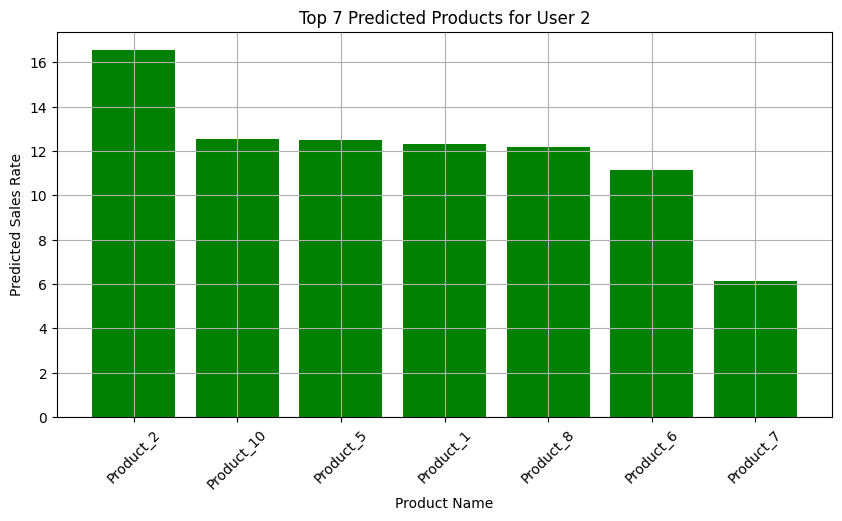

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from datetime import datetime, timedelta

# Constants
num_users=2
NUM_BUSINESS_CATEGORIES = 5
NUM_CATEGORIES = 10
NUM_PRODUCTS_PER_USER = 10
TRANSACTIONS_PER_PRODUCT = 40
PRICE_ELASTICITY = -0.1  # Assuming a negative price elasticity
SEASONALITY_FACTOR = 0.2  # Simulating a seasonality effect

def generate_inventory_data_for_user(user_id, frequency='D', start_date='2020-01-01', end_date='2022-01-01'):
    business_category = f"BusinessCategory_{np.random.randint(1, NUM_BUSINESS_CATEGORIES + 1)}"
    product_categories = [f"ProductCategory_{i+1}" for i in range(NUM_CATEGORIES)]
    products = [f"Product_{i+1}" for i in range(NUM_PRODUCTS_PER_USER)]

    # Time Range
    date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)

    data = []

    for product in products:
        product_category = np.random.choice(product_categories)
        price = np.round(np.random.uniform(5, 500), 2)
        sales_rate = np.round(np.random.uniform(0.1, 20), 2)
        inventory_level = np.random.randint(1, 100)

        # Simulating seasonality and price impact on sales rate
        for date in date_range:
            # Adding randomness with some seasonality effect (e.g., sales boost in December)
            seasonal_factor = 1 + SEASONALITY_FACTOR * np.sin(2 * np.pi * date.month / 12)  # Sinusoidal seasonality effect
            price_impact = np.round(np.random.uniform(0.9, 1.1), 2)  # Price fluctuation factor

            # Adjust sales rate based on price and seasonality
            adjusted_sales_rate = sales_rate * seasonal_factor * price_impact
            transaction_time = date

            data.append([user_id, business_category, product_category, product, price, adjusted_sales_rate, inventory_level, transaction_time])

    df = pd.DataFrame(data, columns=[
        "user_id", "Business Category", "Product Category", "Product Name", "Price",
        "Sales Rate", "Inventory Level", "Transaction Time"
    ])

    return df
# Function to plot synthetic data for each user
def plot_synthetic_data_for_user(user_id, data):
    # Filter data for the specific user
    user_data = data[data['user_id'] == user_id]

    # Convert 'Transaction Time' to datetime if not already
    user_data['Transaction Time'] = pd.to_datetime(user_data['Transaction Time'], errors='coerce')

    # Plot Sales Rate Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(user_data['Transaction Time'], user_data['Sales Rate'], label='Sales Rate', color='blue')

    # Title and labels
    plt.title(f"User {user_id} - Sales Rate Over Time", fontsize=14)
    plt.xlabel("Transaction Time", fontsize=12)
    plt.ylabel("Sales Rate", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Generate data for multiple users
def generate_data_for_multiple_users(num_users):
    all_data = []
    for user_id in range(1, num_users + 1):
        user_data = generate_inventory_data_for_user(user_id=user_id)
        all_data.append(user_data)
        plot_synthetic_data_for_user(user_id,user_data)
    # Concatenate data for all users into a single dataframe
    full_data = pd.concat(all_data, ignore_index=True)
    return full_data

# 2. Prepare Data for Training
def prepare_user_data(data, user_id, lag=5):
    user_data = data[data['user_id'] == user_id].copy()

    # Convert 'date' column to datetime, invalid parsing will result in NaT
    user_data['Transaction Time'] = pd.to_datetime(user_data['Transaction Time'], errors='coerce')
    user_data = user_data.sort_values(by=['Product Name', 'Transaction Time'])

    # Drop rows with NaT values in 'Transaction Time' column
    user_data = user_data.dropna(subset=['Transaction Time'])

    # Add lag features
    for i in range(1, lag + 1):
        user_data[f'lag_{i}'] = user_data.groupby('Product Name')['Sales Rate'].shift(i)

    user_data = user_data.dropna()
    return user_data

# 3. Train a Single Model for a User
def train_model_for_user(data, user_id, lag=5):
    user_data = prepare_user_data(data, user_id, lag)

    features = ['Price', 'Inventory Level', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
    X = user_data[features]
    y = user_data['Sales Rate']

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"User {user_id} - MAE: {mae:.2f}, MSE: {mse:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual Sales Rate', marker='o')
    plt.plot(y_pred, label='Predicted Sales Rate', marker='x')
    plt.title(f"User {user_id} - Actual vs Predicted Sales Rate")
    plt.xlabel("Test Sample")
    plt.ylabel("Sales Rate")
    plt.legend()
    plt.grid(True)
    plt.show

    return model

# 4. Predict Top Products for the User
def predict_top_products(data, user_id, model, future_days=7, lag=5):
    user_data = data[data['user_id'] == user_id]

    # Prepare the data for the latest prediction
    user_data['Transaction Time'] = pd.to_datetime(user_data['Transaction Time'], errors='coerce')
    user_data = user_data.sort_values(by=['Product Name', 'Transaction Time'])

    # Drop rows with NaT values in 'Transaction Time' column
    user_data = user_data.dropna(subset=['Transaction Time'])

    # Add lag features to the latest data for prediction
    for i in range(1, lag + 1):
        user_data[f'lag_{i}'] = user_data.groupby('Product Name')['Sales Rate'].shift(i)

    user_data = user_data.dropna()

    # Get the latest data for each product
    latest_data = user_data.groupby('Product Name').tail(1)  # Get the latest record for each product

    # Prepare features for prediction
    features = ['Price', 'Inventory Level', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

    # Ensure all features are present in the latest data
    latest_data = latest_data[features]

    # Predict future sales rates
    latest_data['predicted_sales_rate'] = model.predict(latest_data)

    # Add the product_name to the latest_data
    latest_data['Product Name'] = user_data.groupby('Product Name')['Product Name'].first().values

    # Sort by predicted sales rate and get top products
    top_products = latest_data.sort_values(by='predicted_sales_rate', ascending=False).head(future_days)

    print(f"Top Predicted Products for User {user_id}:")
    print(top_products[['Product Name', 'predicted_sales_rate']])

    plt.figure(figsize=(10, 5))
    plt.bar(top_products['Product Name'], top_products['predicted_sales_rate'], color='green')
    plt.title(f"Top {future_days} Predicted Products for User {user_id}")
    plt.xlabel("Product Name")
    plt.ylabel("Predicted Sales Rate")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    return top_products

# 5. Execute for Multiple Users
def execute_for_multiple_users(data, num_users):
    for user_id in range(1, num_users + 1):
        print(f"\nTraining and Predicting for User {user_id}...")
        model = train_model_for_user(data, user_id)
        top_products = predict_top_products(data, user_id, model)

# Generate synthetic data for multiple users
data = generate_data_for_multiple_users(num_users)

# Run the process for multiple users
execute_for_multiple_users(data, num_users)
